In [1]:
# Set up to be able to use python for symbolic math help.
from sympy import *
from sympy.assumptions.assume import global_assumptions
from IPython.display import display, Math, Latex # Latex printing in notebook

l, t, m1, m2, g = symbols("l t m1 m2 g", real=True, positive=True)
p1x = Function("p1x", real=True)(t)
theta = Function("theta", real=True)(t)
global_assumptions.add(Q.real(theta.diff(t)))
global_assumptions.add(Q.real(p1x.diff(t)))
thetaDot = theta.diff(t, real=True)

Suppose we have a mass attached to cart depicted in following diagram.

![cart mass system](../images/system.png)

We wish to control the system such that the `m2` mass will remain in the upright and vertical position.
To keep the `m2` mass in the upright vertical position i.e. keeping $\theta = 0$, we will be applying some force `f(t)` on the `m1` mass in the horizontal direction. To determine the magnitude and direction of the force needed to keep the `m2` mass balanced, we will be using a full state feedback controller.

In order create a state feedback controller to balance our `m2` mass, we must first come up with a mathematical model of our system (a.k.a the equations of motion(EOM)). For this exercise, we opted to use [lagrangian mechanics](https://en.wikipedia.org/wiki/Lagrangian_mechanics) to derive our equations of motion.

> Note: We could have derived the EOMs using Newtons 2nd law, but found the math to be much more simple 
> when using the lagrangian.

In order to use the lagrangian, we must fully describe the kinetic and potential energy of the system. This is more easily achieved if we add a few position vectors to our system diagram. ![cart mass system with vectors](../images/system_with_vectors.png)

With the vectors $\vec{p_1}$ and $\vec{p_2}$ we can now describe the kinetic and potential energy as follows.

$$
KE = 1/2 * m_1 \lvert \dot {\vec p_1} \rvert ^2 + 1/2 * m_2 \lvert \dot {\vec p_2} \rvert ^2 \\
\tag{1}
\label{keNotUseful}
$$

$$
PE = m_2 g l cos(\theta) \\
\tag{2}
\label{pe}
$$

While the equation listed at $\eqref{keNotUseful}$ is very true, it is not very helpful. When we go to implement, we will not be able to directly measure or apporixmate $\vec p_2$ or $\dot{\vec p_2}$. We can however, solve for $\vec p_2$ and $\dot{\vec p_2}$ in terms of other variables we can measure and apporixmate such as $\vec p_1$ and $\dot {\vec p_1}$.

> Note: In the controls world, we typically call the variables that we can measure and or calculate in real time states.

Consider our system but while only looking at the following vectors ![system with only vectors](../images/system_vectors_only.png)

We can say that
$$
\vec{p_2} = \vec{p_1} + \Delta \vec{p} \\
\tag{3}
$$

Using the vector diagram, we can substitute useful relationships for $\vec{p_1}$ and $\Delta \vec{p}$ to represent $\vec{p_2}$ in terms states that we can measure or appoximate.

In [2]:
p1Vec = Matrix([p1x, 
                0], real=True)
display(Math(r"\vec{p_1} = {}"), p1Vec)

<IPython.core.display.Math object>

Matrix([
[p1x(t)],
[     0]])

In [3]:
deltaPVec = Matrix([-l*sin(theta),
                   l*cos(theta)], real=True)
display(Math(r"\Delta \vec{p} ="), deltaPVec)

<IPython.core.display.Math object>

Matrix([
[-l*sin(theta(t))],
[ l*cos(theta(t))]])

In [4]:
p2Vec = p1Vec + deltaPVec
display(Math(r"\vec{p_2} = \vec{p_1} + \Delta \vec{p} = "), p2Vec)

<IPython.core.display.Math object>

Matrix([
[-l*sin(theta(t)) + p1x(t)],
[          l*cos(theta(t))]])

We can now use these relationships for $\vec{p_1}$ and $\vec{p_2}$ to determine $\lvert \dot{\vec{p_1}} \rvert$ and $\lvert \dot{\vec{p_2}} \rvert$ in terms of known constants and measurable values. 

In [5]:
p1VecDotNorm = p1Vec.diff(t).norm()
display(Math(r"\lvert \dot{\vec{p_1}} \rvert = "),p1VecDotNorm)

<IPython.core.display.Math object>

Abs(Derivative(p1x(t), t))

In [6]:
p2VecDotNorm = simplify(refine(p2Vec.diff(t).norm()))
display(Math(r"\lvert \dot{\vec{p_2}} \rvert = "), p2VecDotNorm)

<IPython.core.display.Math object>

sqrt(l**2*Derivative(theta(t), t)**2 - 2*l*cos(theta(t))*Derivative(p1x(t), t)*Derivative(theta(t), t) + Derivative(p1x(t), t)**2)

Now that we have $\vec{p_1}, \lvert \dot{\vec{p_1}} \rvert, \vec{p_2}, \lvert \dot{\vec{p_2}} \rvert$ all in terms of useful states, we can express our lagrangian entirely in terms of useful states.

In [7]:
ke = 1/2*m1*p1VecDotNorm**2  + 1/2*m2*p2VecDotNorm**2
pe = m2*g*l*cos(theta)
L = simplify(refine(ke - pe))
display(Math(r"L ="),L)

<IPython.core.display.Math object>

-g*l*m2*cos(theta(t)) + 0.5*m1*Derivative(p1x(t), t)**2 + 0.5*m2*(l**2*Derivative(theta(t), t)**2 - 2*l*cos(theta(t))*Derivative(p1x(t), t)*Derivative(theta(t), t) + Derivative(p1x(t), t)**2)

Now that we have our lagrangian, we can get our equations of motion by evaulating the following.

$$
\frac{d}{dt}\left\lgroup \frac{\partial L}{\partial \dot x}\right\rgroup-\frac{\partial L}{\partial x}=f(t) \\
\tag{4}
\label{eom1}
$$

$$
\frac{d}{dt}\left\lgroup \frac{\partial L}{\partial \dot \theta}\right\rgroup-\frac{\partial L}{\partial \theta}=0 \\
\tag{5}
\label{eom2}
$$

> Note: If you need a refresher of lagrangian mechanics, we found the following videos to be useful.
> - <https://youtu.be/4uJaKJASKnY>
> - <https://youtu.be/uFnTRJ2be7I>

In [8]:
eom1, eom2 = euler_equations(L, [p1x, theta], t)
f = Function("f")
eom1 = eom1.subs(0, -f(t))
display(simplify(eom1))

Eq(f(t), 1.0*m1*Derivative(p1x(t), (t, 2)) + m2*(l*sin(theta(t))*Derivative(theta(t), t)**2 - l*cos(theta(t))*Derivative(theta(t), (t, 2)) + Derivative(p1x(t), (t, 2))))


$$
= \frac{d}{dt}\left\lgroup \frac{\partial L}{\partial \dot x}\right\rgroup-\frac{\partial L}{\partial x}=f(t)
$$

In [9]:
display(simplify(eom2))

Eq(l*m2*(g*sin(theta(t)) - l*Derivative(theta(t), (t, 2)) + cos(theta(t))*Derivative(p1x(t), (t, 2))), 0)

$$
= \frac{d}{dt}\left\lgroup \frac{\partial L}{\partial \dot \theta}\right\rgroup-\frac{\partial L}{\partial \theta}=0 
$$

Now that we have our equations of motion, we want to represent our system in a way that makes it easy to control.
Since we have decided to use a full state feedback controller, we want to represent our system in the following form.

$$
\dot{\vec{x}}= A \vec x + Bu \\ 
\tag{6}
\label{stateEq}
$$

$$
y = C \vec x + Du \\
\tag{7}
\label{outputEq}
$$

> Note: If the **state equation** $\eqref{stateEq}$ or the **output equation** $\eqref{outputEq}$ seams unfamiliar, then we highly suggest watching the following video.
> - <https://youtu.be/hpeKrMG-WP0>

In order to simplify our life and be able to express `A` in terms of only constants, we decide to apply the following simplifications.

> Note: The following appoximations are justified for $-5 ^{\circ} \leq \theta \leq 5 ^{\circ} $
$$
cos\theta \approxeq1 \\ 
sin\theta\approxeq\theta \\ 
$$

> Note: The following appoximation is valid since $\dot\theta$ will be relatively small.
$$
\dot\theta^2\approxeq 0
$$


In [10]:
linearizations = [
    (sin(theta), theta),
    (cos(theta), 1),
    (thetaDot**2, 0)
]
eom1 = eom1.subs(linearizations)
eom1 = simplify(eom1)

eom2 = eom2.subs(linearizations)
eom2 = simplify(eom2)

In [11]:
print("eom1 after linearization")
display(eom1)

eom1 after linearization


Eq(f(t), 1.0*m1*Derivative(p1x(t), (t, 2)) - m2*(l*Derivative(theta(t), (t, 2)) - Derivative(p1x(t), (t, 2))))

In [12]:
print("eom2 after linearization")
display(eom2)

eom2 after linearization


Eq(l*m2*(g*theta(t) - l*Derivative(theta(t), (t, 2)) + Derivative(p1x(t), (t, 2))), 0)

Now that we have linearized our equations of motion, let us explicately say what our states are.
$$
\vec x = \left [
\begin{matrix}
p_{1x} \\
\dot p_{1x} \\
\theta \\
\dot\theta \\
\end{matrix}
\right ] \implies
\dot{\vec x} = \left [
\begin{matrix}
\dot{p_{1x}} \\
\ddot{p_{1x}} \\
\dot{\theta} \\
\ddot{\theta}\\
\end{matrix}
\right ]
$$

We will now solve our equations of motion for $\ddot{\theta}$ and $\ddot{p_{1x}}$. This gets us one step closer to be able to represent our system in the following form
$$
\dot{\vec{x}}= A \vec x + Bu \\
y = C \vec x + Du 
$$

In [13]:
thetaDotDot = thetaDot.diff(t, real=True)
p1xDotDot = p1x.diff(t, real=True).diff(t, real=True)
solution = solve([eom1, eom2], [thetaDotDot, p1xDotDot])

# Getting the solutions of thetaDotDot and p1XDotDot out 
# of a dictionary
thetaDotDot = simplify(solution[thetaDotDot])
p1xDotDot = simplify(solution[p1xDotDot])

In [14]:
display(Math(r"\ddot{\theta} ="), thetaDotDot)

<IPython.core.display.Math object>

(g*m1*theta(t) + g*m2*theta(t) + f(t))/(l*m1)

In [15]:
display(Math(r"\ddot{p_{1x}} = "), p1xDotDot)

<IPython.core.display.Math object>

(g*m2*theta(t) + f(t))/m1

Now that we have expressions for $\ddot{\theta}$ and $\ddot{p_{1x}}$ in terms of our states, we are ready to represent the system in terms of the **state equation** and the **output equation**.

In [16]:
p1xDot = p1x.diff(t)
x = [p1x, p1xDot, theta, thetaDot]
xDot = [p1xDot, p1xDotDot, thetaDot, thetaDotDot]

# type conversions are needed for the linear_eq_to_matrix function call to work
typeConversions = [
    (p1xDot, Symbol("p1xDot")),
    (thetaDot, Symbol("thetaDot")),
    (p1x, Symbol("p1x")),
    (theta, Symbol("theta")),
    (f(t), Symbol("f(t)"))
]

for i in range(len(xDot)):
    xDot[i] = xDot[i].subs(typeConversions)
    x[i] = x[i].subs(typeConversions)

# Gives the variables in the following form 
# xDot = A*x - B*u
APlant, B = linear_eq_to_matrix(xDot, x)

# Changing to the form
# xDot = A*x + B*u
B = -1*B

# Getting f(t) out of the B matrix
B = B.subs(Symbol("f(t)"), 1)

display(Math(r"A ="), APlant)

<IPython.core.display.Math object>

Matrix([
[0, 1,                    0, 0],
[0, 0,              g*m2/m1, 0],
[0, 0,                    0, 1],
[0, 0, (g*m1 + g*m2)/(l*m1), 0]])

In [17]:
display(Math(r"B ="), B)

<IPython.core.display.Math object>

Matrix([
[       0],
[    1/m1],
[       0],
[1/(l*m1)]])

Now is a good time to substitue some actual values for our constants and do some sanity checks.

In [18]:
k1, k2, k3, k4 = symbols(["k1", "k2", "k3", "k4"])
K = Matrix([[k1, k2, k3, k4]])
AClosedLoop = APlant - B*K
display(AClosedLoop)

Matrix([
[         0,          1,                                 0,          0],
[    -k1/m1,     -k2/m1,                   g*m2/m1 - k3/m1,     -k4/m1],
[         0,          0,                                 0,          1],
[-k1/(l*m1), -k2/(l*m1), -k3/(l*m1) + (g*m1 + g*m2)/(l*m1), -k4/(l*m1)]])

In [19]:
s = Symbol("s")
measuredValues = [
    (g, 9.81),
    (m1, 1.0),
    (m2, 2.0),
    (l, 1.0)
]
AClosedLoop = AClosedLoop.subs(measuredValues)
charEq = det(s*eye(4) - AClosedLoop)

In [20]:
# Requirements we are trying to achieve
os = 0.10 # Overshoot
TSetSeconds = 2.0 # Settling time
zet = -ln(os)/sqrt(pi**2 + ln(os)**2)
wn = 4/(zet*TSetSeconds)

desiredCharEq = (s + zet*wn + I*wn*sqrt(1 - zet**2)) * (s + zet*wn - I*wn*sqrt(1 - zet**2)) * (s + 5*wn*zet)**2
desiredCharEq = N(desiredCharEq)
gains = solve(Eq(charEq, desiredCharEq), K)
gainsSub = [
    (k1, gains[k1]),
    (k2, gains[k2]),
    (k3, gains[k3]),
    (k4, gains[k4])
]


In [21]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np
from math import pi

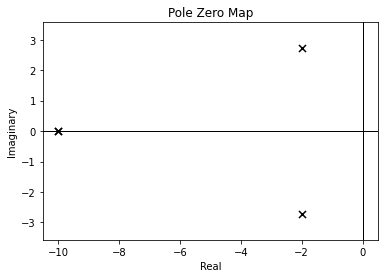

In [22]:
AClosedLoop = AClosedLoop.subs(gainsSub)
APlant = APlant.subs(measuredValues)
B = B.subs(measuredValues)
C = Matrix([[1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0]])
D = Matrix([0,
            0,
            0,
            0])
initialStates = [0, # p1x (m)
                 0, # p1xdot (m/s)
                 5 * pi / 180, # theta (rad)
                 0] # thetadot (rad/sec) 
                        
sys = StateSpace(AClosedLoop, B, C, D)
fig1 = plt.figure()
p1 = pzmap(sys)

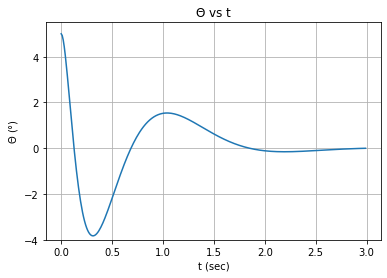

In [23]:
fig2 = plt.figure()
dt = 0.01
T = np.arange(0, 3, dt)
y, t = initial(sys, T, initialStates)
thetaDeg = y[:, 2] * 180/pi
p1 = plt.plot(t, thetaDeg)
plt.title("$\Theta$ vs t")
plt.ylabel("$\Theta$ ($\degree$)")
plt.ylim([-4, 5.5])
plt.xlabel("t (sec)")
plt.grid("on")
